# Online Shoppers Intention Project

## Índice:

- [Lectura de datos](#Lectura-de-datos)
    - [Procesamiento inicial](#Procesamiento-inicial)
    
    
- [Desarrollo con datos sin procesar](#Entrenamiento-con-datos-sin-procesar)
    - [KNN sin procesar](#KNN-sin-procesar)
    - [Árbol de desicion sin procesar](#Árbol-de-desicion-sin-procesar)
    - [Random forest sin procesar](#Random-forest-sin-procesar)
    - [Support vector machine sin procesar](#Support-vector-machine-sin-procesar)


- [Desarrollo con datos sin outliers](#Desarrollo-con-datos-sin-outliers)
    - [Eliminación de los ejemplos outliers](#Eliminación-de-los-ejemplos-outliers)
    - [KNN sin outliers](#KNN-sin-outliers)
    - [Árbol de decision sin outliers](#Árbol-de-decision-sin-outliers)
    - [Random forest sin outliers](#Random-forest-sin-outliers)
    - [Support vector machine sin outliers](#Support-vector-machine-sin-outliers)


- [Comparación de los resultados](#Comparación-de-los-resultados)


- [Selección de instancias](#Selección-de-instancias)
    - [Leave one out](#Leave-one-out)
    - [CNN](#CNN)
    - [RNN](#RNN)
    - [Reducción de ejemplos](#Reducción-de-ejemplos)


- [Selección de variables](#Selección-de-variables)
    - [Visualización de las variables](#Visualización-de-las-variables)
    - [Árbol de desicion con variables reducidas](#Árbol-de-desicion-con-variables-reducidas)
    - [Random forest con variables reducidas](#Random-forest-con-variables-reducidas)
    - [Support vector machine con variables reducidas](#Support-vector-machine-con-variables-reducidas)


- [Validación de modelos](#Validación-de-modelos)
    - [KNN con mejores parametrossin outliers](#KNN-con-mejores-parametros)
    - [Árbol de decision con mejores parametros](#Árbol-de-decision-con-mejores-parametros)
    - [Random forest con mejores parametros](#Random-forest-con-mejores-parametros)
    - [Support vector machine con mejores parametros](#Support-vector-machine-con-mejores-parametros)


- [Entrenamiento con los datos procesados](#Entrenamiento-con-los-datos-procesados)
    - [KNN](#KNN)
    - [Árbol de decision](#Árbol-de-decision)
    - [Random forest](#Random-forest)
    - [Support vector machine](#Support-vector-machine)


- [Evaluación de modelos](#Evaluación-de-modelos)





Autores:
- Jhonny Fabricio, Chicaiza Palomo https://github.com/jhonnyfc
- Hanwei, ke https://github.com/Sendaia

Cargamos las librerías necesarias para el desarrollo del proyecto. 

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn.tree as tree

from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn import neighbors, metrics, model_selection
from sklearn import pipeline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

## Lectura de datos

Visualizar los datos:

In [7]:
datos = pd.read_csv('online_shoppers_intention.csv')
datos_ok = datos.copy()
print(datos_ok.head())

   Administrative  Administrative_Duration  Informational  \
0             0.0                      0.0            0.0   
1             0.0                      0.0            0.0   
2             0.0                     -1.0            0.0   
3             0.0                      0.0            0.0   
4             0.0                      0.0            0.0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0             1.0                 0.000000   
1                     0.0             2.0                64.000000   
2                    -1.0             1.0                -1.000000   
3                     0.0             2.0                 2.666667   
4                     0.0            10.0               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay Month  OperatingSystems  \
0         0.20       0.20         0.0         0.0   Feb                 1   
1         0.00       0.10         0.0         0.0   Feb   

### Procesamiento inicial

Vamos a ver los tipos de variables que tienen nuestros datos.

In [8]:
datos.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

Guardamos los datos categóricos para transformarlos.

In [9]:
categorico = ['Month','Weekend','VisitorType','Revenue']

Como solo vamos a trabajar con los datos numéricos, transformamos todos los datos categóricos.

In [10]:
for i,val in enumerate(datos_ok.columns):
    if val in categorico:
        labels = datos_ok[val].astype('category').cat.categories.tolist()
        dict_make = {val : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}
        datos_ok[val].replace(dict_make[val], inplace=True)

X_all = np.array(datos_ok.drop(columns = 'Revenue').copy())
y_all = np.array(pd.factorize(datos_ok['Revenue'])[0])

Buscamos los valores desconocidos en los dataos.

In [11]:
mascara = np.isnan(X_all)
print('hay',mascara.sum(),'valores desconocidos')

hay 112 valores desconocidos


Eliminamos los ejemplos con valores desconocidos.

In [12]:
mascara = np.sum(mascara,axis=1).reshape(-1,1).astype("bool")
mascara = mascara == False

X = X_all[mascara.flatten()]
y = y_all[mascara.flatten()]
print('se ha eliminado', len(X_all)-len(X),'ejemplos.')

se ha eliminado 14 ejemplos.


Número de elementos de cada clase:

In [13]:
Xpos = X[y == 1]
Xneg = X[y == 0]
print('hay',len(Xpos),'ejemplos de clase positiva')
print('hay',len(Xneg),'ejemplos de clase negativa')

hay 1908 ejemplos de clase positiva
hay 10408 ejemplos de clase negativa


## Desarrollo con datos sin procesar

Primero vamos a probar el rendimiento de los datos sin hacer procesamientos. 

### KNN sin procesar

entrenamos un KNN con los datos sin procesar:

In [14]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7)

clf = neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainKNN = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainKNN))

predTest = clf.predict(X_test)
accTestKNN = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestKNN))

El rendimiento en entrenamiento con todas las variables es el 89.37%
El rendimiento en test con todas las variables es el 86.25%


###  Árbol de desicion sin procesar

entrenamos un arbol de desicion con los datos sin procesar:

In [15]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainDT = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainDT))

predTest = clf.predict(X_test)
accTestDT = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestDT))

El rendimiento en entrenamiento con todas las variables es el 100.0%
El rendimiento en test con todas las variables es el 85.9%


 ### Random forest sin procesar

entrenamos un random forest con los datos sin procesar: 

In [16]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainRF = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainRF))

predTest = clf.predict(X_test)
accTestRF = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestRF))

El rendimiento en entrenamiento con todas las variables es el 98.9%
El rendimiento en test con todas las variables es el 90.15%


### Support vector machine sin procesar

entrenamos un SVM con los datos sin procesar: 

In [17]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.7)

clf = LinearSVC()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainSVM = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainSVM))

predTest = clf.predict(X_test)
accTestSVM = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestSVM))

El rendimiento en entrenamiento con todas las variables es el 69.63%
El rendimiento en test con todas las variables es el 68.44%


##  Desarrollo con datos sin outliers

Ahora vamos a entrenar los clasificadores sin los ejemplos Outliers.

### Eliminación de los ejemplos outliers

In [18]:
def calcularMediaDesviacion(datos):
    media = datos.mean(axis=0)
    desviacion = datos.std(axis=0)
    return media,desviacion

In [19]:
def deteccionOutliers(datos,media,desviacion,k=2):
    variablesOutliers = (datos < (media - k*desviacion)) | (datos > (media + k*desviacion))
    mascaraOutliers = variablesOutliers.sum(axis=1,dtype=bool)
    indicesOutliers = np.array(range(len(datos)))[mascaraOutliers]
    return indicesOutliers

Guardamos las columnas de variables numéricas.

In [20]:
index_col_num = np.ones(len(datos_ok.columns))

for i,val in enumerate(datos_ok.columns):

    if val in categorico:
        index_col_num[i] = 0

## no cogemos la ultima variable porque es la clase
index_col_num = index_col_num[:-1].astype('bool')

Buscamos outliers en las variables numéricas. 

In [21]:
media,desviacion = calcularMediaDesviacion(X.T[index_col_num].T)

indicesOutliers = deteccionOutliers(X.T[index_col_num].T,media,desviacion)
print('existe',len(indicesOutliers), 'filas de Outliers.')

existe 5715 filas de Outliers.


In [22]:
# Borrado de los ejemplos con outliers
XsinOutliers = np.delete(X, indicesOutliers, axis=0)
YsinOutliers = np.delete(y, indicesOutliers, axis=0)
numFilas = len(XsinOutliers)
print('se ha borrado',len(indicesOutliers), 'filas.')
print('ejemplos sin outliers:',numFilas, 'filas.')

se ha borrado 5715 filas.
ejemplos sin outliers: 6601 filas.


Número de ejemplos de cada clase después de eliminar los outliers.

In [23]:
Xpos = XsinOutliers[YsinOutliers == 1]
Xneg = XsinOutliers[YsinOutliers == 0]
print('hay',len(Xpos),'ejemplos de clase positiva.')
print('hay',len(Xneg),'ejemplos de clase negativa.')

hay 820 ejemplos de clase positiva.
hay 5781 ejemplos de clase negativa.


### KNN sin outliers

entrenamos un KNN con los datos sin outliers:

In [24]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(XsinOutliers, YsinOutliers, train_size=0.7)

clf = neighbors.KNeighborsClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainKNNsinOutliers = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainKNNsinOutliers))

predTest = clf.predict(X_test)
accTestKNNsinOutliers = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestKNNsinOutliers))

El rendimiento en entrenamiento con todas las variables es el 90.28%
El rendimiento en test con todas las variables es el 87.68%


### Árbol de decision sin outliers

entrenamos un arbol de desicion con los datos sin outliers:

In [25]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(XsinOutliers, YsinOutliers, train_size=0.7)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainDTsinOutliers = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainDTsinOutliers))

predTest = clf.predict(X_test)
accTestDTsinOutliers = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestDTsinOutliers))

El rendimiento en entrenamiento con todas las variables es el 100.0%
El rendimiento en test con todas las variables es el 86.42%


### Random forest sin outliers

entrenamos un random forest con los datos sin outliers: 

In [26]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(XsinOutliers, YsinOutliers, train_size=0.7)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainRFsinOutliers = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainRFsinOutliers))

predTest = clf.predict(X_test)
accTestRFsinOutliers = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestRFsinOutliers))

El rendimiento en entrenamiento con todas las variables es el 98.87%
El rendimiento en test con todas las variables es el 89.45%


### Support vector machine sin outliers

entrenamos un SVM con los datos sin outliers:

In [27]:
np.random.seed(12)

X_train, X_test, y_train, y_test = model_selection.train_test_split(XsinOutliers, YsinOutliers, train_size=0.7)

clf = LinearSVC()
clf.fit(X_train,y_train)

predTrain = clf.predict(X_train)
accTrainSVMsinOutliers = round(metrics.accuracy_score(y_train,predTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainSVMsinOutliers))

predTest = clf.predict(X_test)
accTestSVMsinOutliers = round(metrics.accuracy_score(y_test,predTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestSVMsinOutliers))

El rendimiento en entrenamiento con todas las variables es el 52.01%
El rendimiento en test con todas las variables es el 51.74%


## Comparación de los resultados

In [28]:
print('KNN ******************************************************************************')

print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainKNN))
print('El rendimiento en entrenamiento con las variables sin outliers es el {}%'.format(accTrainKNNsinOutliers))
print('El rendimiento en test con todas las variables es el {}%'.format(accTestKNN))
print('El rendimiento en test con las variables sin outliers es el {}%'.format(accTestKNNsinOutliers))
print('')

print('Decision Tree ********************************************************************')

print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainDT))
print('El rendimiento en entrenamiento con las variables sin outliers es el {}%'.format(accTrainDTsinOutliers))
print('El rendimiento en test con todas las variables es el {}%'.format(accTestDT))
print('El rendimiento en test con las variables sin outliers es el {}%'.format(accTestDTsinOutliers))
print('')

print('Random Forest ********************************************************************')

print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainRF))
print('El rendimiento en entrenamiento con las variables sin outliers es el {}%'.format(accTrainRFsinOutliers))
print('El rendimiento en test con todas las variables es el {}%'.format(accTestRF))
print('El rendimiento en test con las variables sin outliers es el {}%'.format(accTestRFsinOutliers))
print('')

print('SVM ******************************************************************************')

print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainSVM))
print('El rendimiento en entrenamiento con las variables sin outliers es el {}%'.format(accTrainSVMsinOutliers))
print('El rendimiento en test con todas las variables es el {}%'.format(accTestSVM))
print('El rendimiento en test con las variables sin outliers es el {}%'.format(accTestSVMsinOutliers))


KNN ******************************************************************************
El rendimiento en entrenamiento con todas las variables es el 89.37%
El rendimiento en entrenamiento con las variables sin outliers es el 90.28%
El rendimiento en test con todas las variables es el 86.25%
El rendimiento en test con las variables sin outliers es el 87.68%

Decision Tree ********************************************************************
El rendimiento en entrenamiento con todas las variables es el 100.0%
El rendimiento en entrenamiento con las variables sin outliers es el 100.0%
El rendimiento en test con todas las variables es el 85.9%
El rendimiento en test con las variables sin outliers es el 86.42%

Random Forest ********************************************************************
El rendimiento en entrenamiento con todas las variables es el 98.9%
El rendimiento en entrenamiento con las variables sin outliers es el 98.87%
El rendimiento en test con todas las variables es el 90.15%
El

## Selección de instancias

### Leave one out

In [29]:
def leaveOneOut(clasificador, X, y):
    """
    :param clasificador: Instancia de un clasificador de Scikit-Learn entrenada (con fit hecho con los datos de train o el subconjunto seleccionado)
    :param X: Matriz con los ejemplos de entrenamiento completo (para hacer leave one out)
    :param y: Vector con la salida de los ejemplos de entrenamiento completo (correspondientes a X)
    :return: Vector con la salida obtenida para cada ejemplo de X (siguiendo el esquema leave-one-out)
    """
    # En caso de que el clasificador no sea KNN simplemente se utiliza el clasificador aprendido y se predicen los ejemplos con dicho clasificador
    if type(clasificador) != neighbors.KNeighborsClassifier:
        # Utiliza el método predict para obtener la predicción
        prediction = clasificador.predict(X)
        return prediction
    
    # En otro caso será una instancia de KNeighborsClassifier
    # kneighbors nos devuelve los vecinos más cercanos de cada ejemplo en X y las distancias asociadas
        # distancias y vecinos serán matrices de numEjemplos x k+1 elementos
    distancias, vecinos = clasificador.kneighbors(X, n_neighbors=clasificador.n_neighbors + 1, return_distance=True)
    # Realmente no estamos interesados en el propio vecino, sino en la clase a la que pertenece
    # Transformamos los vecinos a una matriz con la clase de cada vecino
    # Accedemos a las clases de los ejemplos de entrenamiento (atributo -y del clasificador knn) 
        # y cogemos los elementos en las posiciones de los vecinos calculados anteriormente
    vecinosClase = clasificador._y[vecinos] # probar si funciona igual porque entiendo que si y es mucho más fácil (para train va mal)
    
    # Ahora queda decidir la clase de salida para cada uno de los ejemplos
    # Debemos tener en cuenta: Si la distancia al primer vecino es 0, el vecino es el propio ejemplo y por tanto no lo usamos para decidir
    #   1. Obtenemos una máscara con los ejemplos en los que ocurre esto
    #   2. Sustituimos la clase del primer vecino por la del último (el k+1 que sino no se utiliza)
    #   3. Obtenemos la moda (stats.mode) (el valor más repetido de clase) para cada fila (cogiendo los k primeros valores)
    mascara = distancias[:,0] == 0
    vecinosClase[mascara,0] = vecinosClase[mascara,-1]
    prediction =  stats.mode(vecinosClase[:,:-1],axis=1)[0]

    return prediction

### CNN

In [30]:
def CNN(X, y, k=1):
    """
    Algoritmo CNN para la selección de instancias. Se comienza con dos ejemplos aleatorios (uno de cada clase) y cada ejemplo
    que se falla al ser clasificado por los ya seleccionados se añade a la selección (se para cuando ya no se añaden más ejemplos)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = np.zeros((X.shape[0]),dtype=bool)

    # Inicialmente, seleccionamos aleatoriamente una instancia de cada clase
    # Anotamos el número de clases
    nClases = np.unique(y)

    # Para cada clase, buscamos los índices de los ejemplos de dicha clase y seleccionamos uno de ellos aleatoriamente
    # Dicho ejemplo coge el valor True en S
    for c in nClases:
        indicesClase = np.where(y == c)[0]  # np.where devuelve una tupla, nos interesa la primera parte que contiene los índices de las posiciones que no son 0 o False
        # Elegid una instancia aleatoriamente de las de la clase: utilizad randint de Numpy para ello
        instanciaAleatoria = indicesClase[np.random.randint(0,indicesClase.size)]
        # Modificad la máscara S de acuerdo a la instancia seleccionada
        S[instanciaAleatoria] = True

    # Solo evaluamos los ejemplos que no están en S (los que están se aciertan por definición al considerlos
    # como vecinos de sí mismos). Estos ejemplos son los únicos que podemos añadir a S
    notS = S == False

    # "Entrenamos" knn con los ejemplos seleccionados
    knn.fit(X[S,:],y[S])
    
    # Inicializamos el número de fallados para entrar en el bucle. El algoritmo termina cuando no se fallan ejemplos
    fallados = -1
    while fallados != 0:
        # Ponemos el contador de fallados a 0 y comprobamos todos los ejemplos no seleccionados
        fallados = 0
        # Obtenemos los índices de los ejemplos no seleccionados: utilizad np.where como se ha hecho anteriormente
        indices = np.where(notS)[0]

        # Para cada ejemplo no seleccionado (y en orden aleatorio) comprobamos si dicho ejemplo se falla         
        # con las instancias en S actualmente. Si se falla, el ejemplo se añade a S, se reentrena KNN y se suma uno a fallados
        for i in np.random.permutation(indices):
            if y[i] != knn.predict(X[i, :].reshape(1, -1)):
                S[i] = True
                knn = knn.fit(X[S, :], y[S])
                fallados += 1

        # Recalculamos los ejemplos a estudiar en la próxima iteración, aquellos no seleccionados
        notS = np.logical_not(S)
        print("CNN, fin de iteración, fallados: {}, ejemplos en S: {}".format(fallados, np.sum(S)))

    return S

### RNN

In [31]:
def RNN(X, y, k=1):
    """
    Algoritmo RNN para la selección de instancias. Se parte de la selección obtenida con CNN y se eliminan aquellas instancias
    que no provoquen que se falle ninguna instancia no seleccionada (las seleccionadas se aciertan por definición al estar en el subconjunto)
    :param X: Matriz con los ejemplos de entrenamiento (se asume que los ejemplos están normalizados)
    :param y: Vector con la salida de los ejemplos en X
    :param k: Valor de k a utilizar en ENN
    :return: Vector con la máscara de instancias seleccionadas 
            (La posición S[i]=True indica que la instancia i ha sido seleccionada y False lo contrario)
    """
    # Como usamos aleatorios en RNN establecemos la semilla para que el test sea correcto y siempre obtengamos el mismo resultado
    np.random.seed(12312)
    # Creamos el clasificador knn con el valor de k dado
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)

    # En RNN partimos de la selección realizada por CNN y eliminamos ejemplos de la misma
    # S es una máscara de booleanos que indica si el ejemplo en la posición i está seleccionado (True) o no lo está (False)
    S = CNN(X,y,k)

    # Entrenamos KNN con el conjunto de instancias seleccionadas por CNN
    knn.fit(X[S,:],y[S])

    # Obtenemos la máscara de instancias no seleccionadas
    # No podemos fallar ninguna de estas si queremos eliminar una instancia de S
    notS = S == False

    # Recorremos las instancias seleccionadas para ver si podemos eliminarlas o no
    # Obtenemos para ello los índices de las instancias: utilizad np.where
    indices = np.where(S)[0]

    # y las recorremos aleatoriamente:
    for i in np.random.permutation(indices):
        # Asumimos que podemos eliminar la instancia y la "eliminamos" temporalmente: intercambio de valores en las máscaras S y Snot
        S[i],notS[i] = notS[i],S[i]

        # Entrenamos knn una vez eliminada la instancia
        knn.fit(X[S,:],y[S])

        # Obtenemos las salidas para los ejemplos que no están seleccionados
        salidas = knn.predict(X[notS,:])

        # Si todos los ejemplos no seleccionados son acertados (no se falla ninguno) mantenemos la eliminación (no hacemos nada)
            # En otro caso, si fallamos alguna instancia, debemos restablecer la instancia eliminada: deshacer el intercambio en las máscaras
        if np.sum(y[notS] != salidas) != 0:
            S[i], notS[i] = notS[i], S[i]

    return S

In [32]:
def ejecutaMetodoIS(funcionMetodo, clasificador, X_train, y_train, X_test, y_test, verbose=True):  
    """
    Esta función se encajar de ejecutar un método de selección de instancias y dar los resultados sobre train y test
    con el clasificador introducido como parámetro
    :param funcionMetodo: Función con el método de selección de instancias a ejecutar
    :param clasificador: Instancia del clasificador a utilizar para obtener la precisión en train y test
    :param train: Conjunto de datos de entrenamiento leído del formato keel con campos data y target
    :param test: Conjunto de datos de test leído del formato keel con campos data y target
    :return: tupla con la máscara de ejemplos seleccionados, la precisión en train, precisión en test y porcentaje de reducción obtenido
    """
    
    # Obtenemos el nombre del método. Como es una función utilizamos su campo __name__
    nombreMetodo = funcionMetodo.__name__
    if verbose:
        print ("Ejecutando " + nombreMetodo + "...")
    # Ejecutamos el método de selección de instancias correspondiente con los ejemplos de entrenamiento y sus clases
        # Utilizad todos los métodos con los parámetros por defecto y almacenad la máscara devuelta en una variable llamada S
    S = funcionMetodo(X_train,y_train)
    
    # Entrenamos el clasificador correspondiente solo con los ejemplos seleccionados (aplicamos la máscara S)
    clasificador.fit(X_train[S,:],y_train[S])

#     # Obtenemos las salidas para train mediante leaveOneOut
    predictionTrain = leaveOneOut(clasificador,X_train,y_train)

#     # Obtenemos la precisión en train con las salidas obtenidas (tanto por uno)
    accTrain = metrics.accuracy_score(predictionTrain,y_train)

#     # Obtenemos las salidas para test 
#     # Obtenemos la precisión en test  (tanto por uno)
    accTest = clasificador.score(X_test,y_test)

    # Calculamos el porcentaje de reducción
    reduction = 100 - S.sum() / float(S.size)*100

    if verbose:
        # print("Dataset " + dataset)
        print("Resultados " + nombreMetodo + " python")
        print("Precisión en train: {}".format(accTrain))
        print("Precisión en test: {}".format(accTest))
        print("Reducción " + nombreMetodo + ": {} de {}".format(S.sum(), S.size))
        print("Reducción: %2.2f%%" % reduction)
        # En caso de ser un árbol, imprimimos el número de reglas obtenidas
        if type(clasificador) == tree.DecisionTreeClassifier:
            print("Número de reglas: {}".format(clasificador.tree_.node_count))

    # Mostramos los resultados obtenidos por el método gráficamente
    # mostrar(clasificador, X_train, y_train, X_test, y_test,  nombreMetodo, X_train[S, :], y_train[S])

    # Si es un árbol, devolvemos el número de reglas obtenidas
    nReglas = -1
    if type(clasificador) == tree.DecisionTreeClassifier:
        nReglas = clasificador.tree_.node_count
    return S, accTrain, accTest, reduction, nReglas

### Reducción de ejemplos

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(XsinOutliers, YsinOutliers, train_size=0.7)
XsinOutliers.shape

(6601, 17)

probamos con CNN.

In [34]:
%%time
clf = neighbors.KNeighborsClassifier()
indicesCNN, accTrain, accTest, reduction, _ = ejecutaMetodoIS(CNN, clf, X_train, y_train, X_test, y_test)

Ejecutando CNN...
CNN, fin de iteración, fallados: 1080, ejemplos en S: 1082
CNN, fin de iteración, fallados: 329, ejemplos en S: 1411
CNN, fin de iteración, fallados: 56, ejemplos en S: 1467
CNN, fin de iteración, fallados: 4, ejemplos en S: 1471
CNN, fin de iteración, fallados: 1, ejemplos en S: 1472
CNN, fin de iteración, fallados: 0, ejemplos en S: 1472
Resultados CNN python
Precisión en train: 0.8432900432900433
Precisión en test: 0.872791519434629
Reducción CNN: 1472 de 4620
Reducción: 68.14%
Wall time: 34.1 s


probamos con RNN.

In [35]:
%%time
knn = neighbors.KNeighborsClassifier()
indicesRNN, accTrain, accTest, reduction, _ = ejecutaMetodoIS(RNN, knn, X_train, y_train, X_test, y_test)

Ejecutando RNN...
CNN, fin de iteración, fallados: 1080, ejemplos en S: 1082
CNN, fin de iteración, fallados: 329, ejemplos en S: 1411
CNN, fin de iteración, fallados: 56, ejemplos en S: 1467
CNN, fin de iteración, fallados: 4, ejemplos en S: 1471
CNN, fin de iteración, fallados: 1, ejemplos en S: 1472
CNN, fin de iteración, fallados: 0, ejemplos en S: 1472
Resultados RNN python
Precisión en train: 0.8298701298701299
Precisión en test: 0.8712771327612318
Reducción RNN: 1227 de 4620
Reducción: 73.44%
Wall time: 7min 8s


Como RNN tiene mayor tasa de reducción, vamos a aplicarlo a todos los ejemplos sin outliers.

In [36]:
%%time
indicesIS = RNN(XsinOutliers,YsinOutliers)

CNN, fin de iteración, fallados: 1507, ejemplos en S: 1509
CNN, fin de iteración, fallados: 473, ejemplos en S: 1982
CNN, fin de iteración, fallados: 56, ejemplos en S: 2038
CNN, fin de iteración, fallados: 1, ejemplos en S: 2039
CNN, fin de iteración, fallados: 0, ejemplos en S: 2039


In [37]:
indicesIS.shape

(6601,)

aplicamos la mascara a los datos sin Outliers.

In [38]:
XsinOutliers = XsinOutliers[indicesIS]
YsinOutliers = YsinOutliers[indicesIS]
XsinOutliers.shape

(1680, 17)

In [52]:
Xpos = XsinOutliers[YsinOutliers == 1]
Xneg = XsinOutliers[YsinOutliers == 0]
print('hay',len(Xpos),'ejemplos de clase positiva')
print('hay',len(Xneg),'ejemplos de clase negativa')

hay 595 ejemplos de clase positiva
hay 1085 ejemplos de clase negativa


## Selección de variables

### Visualización de las variables

Wall time: 14.5 s


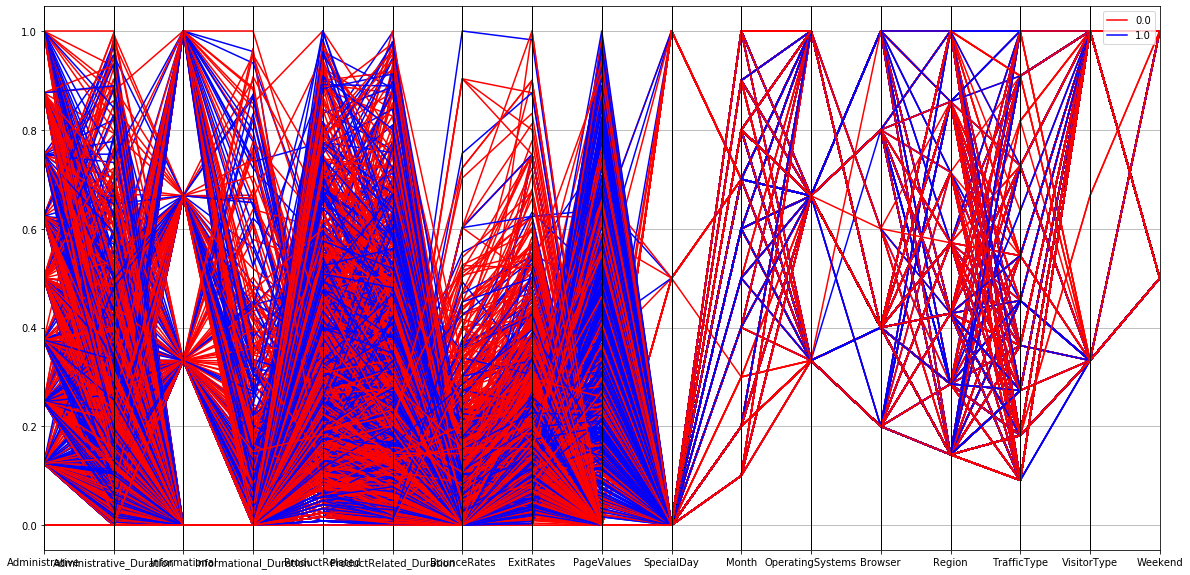

In [98]:
%%time
from pandas.plotting import parallel_coordinates

datos = np.hstack((XsinOutliers, YsinOutliers.reshape(-1,1)))
datos = datos / datos.max(axis=0)
# Se crean los índices de los ejemplos
indice = list(range(0,len(XsinOutliers)))

# Se obtienen los nombres de las variables (entrada y salida)
columnas = list(datos_ok.columns[:-1])
columnas.append('clase')

# Se genera el DataFrame para poder aplicar la función parallel_coordinates
df = pd.DataFrame(data = datos, index=indice, columns=columnas)

# Se aplica la función parallel_coordinates sobre el DataFrame generado y usando la Clase como variable de discriminación
plt.figure(figsize=(20,10))
pd.plotting.parallel_coordinates(df,class_column='clase',color=['r','b'])

como podemos ver, la grafica no nos aporta mucha informacion, por lo tanto, seleccionaremos las variables mas importantes con la ayuda de la libreria feature_selection, pero hay que destacar que la variable PageValues parece tener una gran importancia.

### Árbol de decisión con variables reducidas

vamos a buscar los mejores variables para DT:

In [41]:
np.random.seed(12)
semilla = 123

clf = tree.DecisionTreeClassifier()

modelDT = SelectFromModel(estimator=clf)
modelDT.fit(XsinOutliers, YsinOutliers)

X_newDT = modelDT.transform(XsinOutliers)

booleanas =  modelDT.get_support()

# Se obtienen los nombres de las variables seleccionadas
variablesSeleccionadasDT = [datos_ok.columns[:-1][i] for i in range(len(datos_ok.columns)-1) if booleanas[i]==True]
print("Las variables seleccionadas son:", variablesSeleccionadasDT)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_newDT, YsinOutliers, train_size=0.7)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train,y_train)

# Predicción de las clases de los datos de entrenamiento transformados
prediccionesTrain = clf.predict(X_train)
prediccionesTest = clf.predict(X_test)

# Se obtiene el accuracy en enrenamiento del nuevo árbol
accTrainDTfs =  round(metrics.accuracy_score(y_train,prediccionesTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainDTfs))

# Obtenición del rendimiento con los datos de test
accTestDTfs =  round(metrics.accuracy_score(y_test,prediccionesTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestDTfs))

Las variables seleccionadas son: ['Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'Month']
El rendimiento en entrenamiento con todas las variables es el 100.0%
El rendimiento en test con todas las variables es el 66.27%


### Random forest con variables reducidas

vamos a buscar los mejores variables para RF:

In [42]:
np.random.seed(12)
semilla = 123

clf = RandomForestClassifier()

modelRF = SelectFromModel(estimator=clf)
modelRF.fit(XsinOutliers, YsinOutliers)

X_newRF = modelRF.transform(XsinOutliers)

booleanas =  modelRF.get_support()

# Se obtienen los nombres de las variables seleccionadas
variablesSeleccionadasRF = [datos_ok.columns[:-1][i] for i in range(len(datos_ok.columns)-1) if booleanas[i]==True]
print("Las variables seleccionadas son:", variablesSeleccionadasRF)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_newRF, YsinOutliers, train_size=0.7)

clf = RandomForestClassifier()
clf.fit(X_train,y_train)

# Predicción de las clases de los datos de entrenamiento transformados
prediccionesTrain = clf.predict(X_train)
prediccionesTest = clf.predict(X_test)

# Se obtiene el accuracy en enrenamiento del nuevo árbol
accTrainRFfs =  round(metrics.accuracy_score(y_train,prediccionesTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainRFfs))

# Obtenición del rendimiento con los datos de test
accTestRFfs =  round(metrics.accuracy_score(y_test,prediccionesTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestRFfs))

Las variables seleccionadas son: ['Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month']
El rendimiento en entrenamiento con todas las variables es el 98.3%
El rendimiento en test con todas las variables es el 69.84%


### Support vector machine con variables reducidas

vamos a buscar los mejores variables para SVM:

In [43]:
np.random.seed(12)
semilla = 123

clf = LinearSVC()

modelSVM = SelectFromModel(estimator=clf)
modelSVM.fit(XsinOutliers, YsinOutliers)

X_newSVM = modelSVM.transform(XsinOutliers)

booleanas =  modelSVM.get_support()

# Se obtienen los nombres de las variables seleccionadas
variablesSeleccionadasSVM = [datos_ok.columns[:-1][i] for i in range(len(datos_ok.columns)-1) if booleanas[i]==True]
print("Las variables seleccionadas son:", variablesSeleccionadasSVM)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_newSVM, YsinOutliers, train_size=0.7)

clf = LinearSVC()
clf.fit(X_train,y_train)

# Predicción de las clases de los datos de entrenamiento transformados
prediccionesTrain = clf.predict(X_train)
prediccionesTest = clf.predict(X_test)

# Se obtiene el accuracy en enrenamiento del nuevo árbol
accTrainSVMfs =  round(metrics.accuracy_score(y_train,prediccionesTrain)*100,2)
print('El rendimiento en entrenamiento con todas las variables es el {}%'.format(accTrainSVMfs))

# Obtenición del rendimiento con los datos de test
accTestSVMfs =  round(metrics.accuracy_score(y_test,prediccionesTest)*100,2)
print('El rendimiento en test con todas las variables es el {}%'.format(accTestSVMfs))

Las variables seleccionadas son: ['Informational', 'ExitRates', 'SpecialDay', 'OperatingSystems', 'VisitorType', 'Weekend']
El rendimiento en entrenamiento con todas las variables es el 64.8%
El rendimiento en test con todas las variables es el 63.69%


El porcentaje de aciertos para SVM se ha mejorado considerablemente, ademas, las variables mas importantes para SVM son completamente distintos que las de arbol de decision y random forest.

## Validación  de modelos

### KNN con mejores parametros

Validación para KNN:

Como el model_selection no permite KNN, usamos todos los variables.

In [44]:
%%time
semilla = 12

listaRendimiento = ['precision', 'recall','accuracy','f1','roc_auc']

for tipoRendimiento in listaRendimiento:
    
    modeloReg = neighbors.KNeighborsClassifier()
    grid = {'n_neighbors': [1, 3, 5, 7, 9], 'weights': ['uniform', 'distance'], 'p': [1, 2, 1.5, 3]}

    # Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
    clasificadores = model_selection.GridSearchCV(modeloReg, 
                                                  grid, 
                                                  scoring=tipoRendimiento, 
                                                  cv=10,
                                                  return_train_score=True
                                                 )
    # Entrenamiento de todos los clasificadores con todos los datos contenidos en ion (campos data y target)
    clasificadores.fit(XsinOutliers,YsinOutliers)

    # Se muestra la mejor configuración y su accuracy asociado
    print("mejor",tipoRendimiento,':',clasificadores.best_score_)
    print("mejor configuracion: ",clasificadores.best_params_)
    # print('********************************************************************************')

    # # Se muestra el accuracy obtenido para cada posible combinación de parámetros
    # resultadosMostrar = zip(clasificadores.cv_results_['params'],clasificadores.cv_results_['mean_test_score'],clasificadores.cv_results_['mean_train_score'])
    # for params, mean_test_score, mean_train_score in resultadosMostrar:
    #     print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    #     print()

mejor precision : 0.31898699062958513
mejor configuracion:  {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
mejor recall : 0.12092026499865481
mejor configuracion:  {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
mejor accuracy : 0.6089285714285714
mejor configuracion:  {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
mejor f1 : 0.16543555393847878
mejor configuracion:  {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
mejor roc_auc : 0.4468556105484979
mejor configuracion:  {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Wall time: 5min 33s


### Árbol de decision con mejores parametros

Validación para árbol de decision:

In [45]:
%%time
np.random.seed(12)

for tipoRendimiento in listaRendimiento:
    clfTree = tree.DecisionTreeClassifier()

    param_grid = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 5, 10, 15], 'min_samples_leaf': [1, 2, 4]}
    numParticiones = 10
    devolverResultadosTrain = True

    # Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
    clasificadores = model_selection.GridSearchCV(clfTree,
                                                  param_grid,
                                                  scoring=tipoRendimiento,
                                                  cv=numParticiones,
                                                  return_train_score=devolverResultadosTrain)

    clasificadores.fit(X_newDT,YsinOutliers)

    # Se muestra la mejor configuración y su accuracy asociado
    print("mejor",tipoRendimiento,':',clasificadores.best_score_)
    print("mejor configuracion: ",clasificadores.best_params_)
    #print('********************************************************************************')

    # Se muestra el accuracy obtenido para cada posible combinación de parámetros
    # resultadosMostrar = zip(clasificadores.cv_results_['params'],clasificadores.cv_results_['mean_test_score'],clasificadores.cv_results_['mean_train_score'])
    # for params, mean_test_score, mean_train_score in resultadosMostrar:
    #     print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    #     print()

mejor precision : 0.5900718954887113
mejor configuracion:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 3}
mejor recall : 0.5309550712940543
mejor configuracion:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 15}
mejor accuracy : 0.6904761904761905
mejor configuracion:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 15}
mejor f1 : 0.5486211136961117
mejor configuracion:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 5}
mejor roc_auc : 0.7180587968722104
mejor configuracion:  {'criterion': 'gini', 'min_samples_leaf': 4, 'min_samples_split': 15}
Wall time: 38.9 s


### Random forest con mejores parametros

No vamos a hacer la validacion de random forest porque tarda demaciado, posteriormente ultilizarémos los mejores parametros de arbol de decision y los demas por defecto.

In [ ]:
%%time
np.random.seed(12)

for tipoRendimiento in listaRendimiento:
    clf = RandomForestClassifier()

    param_grid = {'n_estimators': [10,50,100], 
                'max_features': [1,'sqrt','log2',None], 
                'criterion': ['gini','entropy'],
                'max_depth': [5,10,None],
                'min_samples_split': [2,10,20]}
    numParticiones = 10
    devolverResultadosTrain = True

    # Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
    clasificadores = model_selection.GridSearchCV(clf,
                                                  param_grid,
                                                  scoring=tipoRendimiento,
                                                  cv=numParticiones,
                                                  return_train_score=devolverResultadosTrain)

    clasificadores.fit(X_newRF,YsinOutliers)

    # Se muestra la mejor configuración y su accuracy asociado
    print("mejor",tipoRendimiento,':',clasificadores.best_score_)
    print("mejor configuracion: ",clasificadores.best_params_)
    #print('********************************************************************************')

    # Se muestra el accuracy obtenido para cada posible combinación de parámetros
    # resultadosMostrar = zip(clasificadores.cv_results_['params'],clasificadores.cv_results_['mean_test_score'],clasificadores.cv_results_['mean_train_score'])
    # for params, mean_test_score, mean_train_score in resultadosMostrar:
    #     print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    #     print()

mejor precision : 0.7218466931803063
mejor configuracion:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 1, 'min_samples_split': 20, 'n_estimators': 50}


### Support vector machine con mejores parametros

Validación para árbol de decision:

In [46]:
%%time
np.random.seed(12)

for tipoRendimiento in listaRendimiento:
    clf = LinearSVC()

    C_values = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
    param_grid = {'C': C_values}
    numParticiones = 10
    devolverResultadosTrain = True

    # Llamada la función GridSearchCV que nos crea todas las cominaciones del grid anterior
    clasificadores = model_selection.GridSearchCV(clf,
                                                  param_grid,
                                                  scoring=tipoRendimiento,
                                                  cv=numParticiones,
                                                  return_train_score=devolverResultadosTrain)

    clasificadores.fit(X_newSVM,YsinOutliers)

    # Se muestra la mejor configuración y su accuracy asociado
    print("mejor",tipoRendimiento,':',clasificadores.best_score_)
    print("mejor configuracion: ",clasificadores.best_params_)
    #print('********************************************************************************')

    # Se muestra el accuracy obtenido para cada posible combinación de parámetros
    # resultadosMostrar = zip(clasificadores.cv_results_['params'],clasificadores.cv_results_['mean_test_score'],clasificadores.cv_results_['mean_train_score'])
    # for params, mean_test_score, mean_train_score in resultadosMostrar:
    #     print("%0.3f (Train: %0.3f) for %r" % (mean_test_score, mean_train_score, params))
    #     print()

mejor precision : 0.4205754808026179
mejor configuracion:  {'C': 30}
mejor recall : 0.24872814097390367
mejor configuracion:  {'C': 30}
mejor accuracy : 0.6458333333333334
mejor configuracion:  {'C': 1}
mejor f1 : 0.2270930933663045
mejor configuracion:  {'C': 100}
mejor roc_auc : 0.5954881261249181
mejor configuracion:  {'C': 3}
Wall time: 1min 12s


## Entrenamiento con los datos procesados

### KNN

In [92]:
np.random.seed(12)

clfKNN = neighbors.KNeighborsClassifier(n_neighbors= 9, p= 1, weights= 'uniform')
clfKNN.fit(XsinOutliers,YsinOutliers)

print('entrenamos con',len(XsinOutliers),'ejemplos:')
## En train usamos los ejemplos seleccionados
predTrain = clfKNN.predict(XsinOutliers)
accTrain = round(metrics.accuracy_score(YsinOutliers,predTrain)*100,2)
print('El rendimiento de entrenamiento es el {}%'.format(accTrain))

print('predecimos',len(X),'ejemplos:')
## En test usamos todos los ejemplos
predTest = clfKNN.predict(X)
accTest = round(metrics.accuracy_score(y,predTest)*100,2)
print('El rendimiento con todas las variables es el {}%'.format(accTest))

entrenamos con 1680 ejemplos:
El rendimiento de entrenamiento es el 66.9%
predecimos 12316 ejemplos:
El rendimiento con todas las variables es el 85.66%


### Árbol de decision

In [59]:
np.random.seed(12)

clfDT = tree.DecisionTreeClassifier(criterion= 'gini', min_samples_leaf= 4, min_samples_split= 15)
clfDT.fit(X_newDT,YsinOutliers)

print('entrenamos con',len(X_newDT),'ejemplos:')
## En train usamos los ejemplos seleccionados
predTrain = clfDT.predict(X_newDT)
accTrain = round(metrics.accuracy_score(YsinOutliers,predTrain)*100,2)
print('El rendimiento de entrenamiento es el {}%'.format(accTrain))

print('predecimos',len(X),'ejemplos:')
## En test usamos todos los ejemplos
predTest = clfDT.predict(modelDT.transform(X))
accTest = round(metrics.accuracy_score(y,predTest)*100,2)
print('El rendimiento con todas las variables es el {}%'.format(accTest))


entrenamos con 1680 ejemplos:
El rendimiento de entrenamiento es el 87.5%
predecimos 12316 ejemplos:
El rendimiento con todas las variables es el 83.08%


### Random forest

In [60]:
np.random.seed(12)

clfRF = RandomForestClassifier(criterion= 'gini', min_samples_leaf= 4, min_samples_split= 15)
clfRF.fit(X_newRF,YsinOutliers)

print('entrenamos con',len(X_newRF),'ejemplos:')
## En train usamos los ejemplos seleccionados
predTrain = clfRF.predict(X_newRF)
accTrain = round(metrics.accuracy_score(YsinOutliers,predTrain)*100,2)
print('El rendimiento de entrenamiento es el {}%'.format(accTrain))

print('predecimos',len(X),'ejemplos:')
## En test usamos todos los ejemplos
predTest = clfRF.predict(modelRF.transform(X))
accTest = round(metrics.accuracy_score(y,predTest)*100,2)
print('El rendimiento con todas las variables es el {}%'.format(accTest))

entrenamos con 1680 ejemplos:
El rendimiento de entrenamiento es el 86.19%
predecimos 12316 ejemplos:
El rendimiento con todas las variables es el 89.04%


### Support vector machine

In [91]:
np.random.seed(12)

clfSVM = LinearSVC(C= 1)
clfSVM.fit(X_newSVM,YsinOutliers)

print('entrenamos con',len(X_newSVM),'ejemplos:')
## En train usamos los ejemplos seleccionados
predTrain = clfSVM.predict(X_newSVM)
accTrain = round(metrics.accuracy_score(YsinOutliers,predTrain)*100,2)
print('El rendimiento de entrenamiento es el {}%'.format(accTrain))

print('predecimos',len(X),'ejemplos:')
## En test usamos todos los ejemplos
predTest = clfSVM.predict(modelSVM.transform(X))
accTest = round(metrics.accuracy_score(y,predTest)*100,2)
print('El rendimiento con todas las variables es el {}%'.format(accTest))

entrenamos con 1680 ejemplos:
El rendimiento de entrenamiento es el 64.52%
predecimos 12316 ejemplos:
El rendimiento con todas las variables es el 84.37%


## Evaluación de modelos

In [ ]:
def EvaluacionDeModelos(clf,model = None):
    
    if model == None:
        pred = clf.predict(X)
    else:
        pred = clf.predict(model.transform(X))
    
    print('Matriz de confusión: ')
    matrizConfusion = metrics.confusion_matrix(y,pred)
    print(pd.DataFrame(dict(zip(['pred = clase 0','pred = clase 1'],
                                    [matrizConfusion[:,0],matrizConfusion[:,1]])) ,
                                   index = ['clase 0','clase 1']))
    print('Medidas de calidad: ')
    print(metrics.classification_report(y, pred))
    
    

In [93]:
EvaluacionDeModelos(clfKNN)

Matriz de confusión: 
         pred = clase 0  pred = clase 1
clase 0           10174             234
clase 1            1532             376

              precision    recall  f1-score   support

           0       0.87      0.98      0.92     10408
           1       0.62      0.20      0.30      1908

    accuracy                           0.86     12316
   macro avg       0.74      0.59      0.61     12316
weighted avg       0.83      0.86      0.82     12316



In [94]:
EvaluacionDeModelos(clfDT,modelDT)

Matriz de confusión: 
         pred = clase 0  pred = clase 1
clase 0            8926            1482
clase 1             602            1306

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     10408
           1       0.47      0.68      0.56      1908

    accuracy                           0.83     12316
   macro avg       0.70      0.77      0.73     12316
weighted avg       0.86      0.83      0.84     12316



In [95]:
EvaluacionDeModelos(clfRF,modelRF)

Matriz de confusión: 
         pred = clase 0  pred = clase 1
clase 0            9567             841
clase 1             509            1399

              precision    recall  f1-score   support

           0       0.95      0.92      0.93     10408
           1       0.62      0.73      0.67      1908

    accuracy                           0.89     12316
   macro avg       0.79      0.83      0.80     12316
weighted avg       0.90      0.89      0.89     12316



In [96]:
EvaluacionDeModelos(clfSVM,modelSVM)

Matriz de confusión: 
         pred = clase 0  pred = clase 1
clase 0           10386              22
clase 1            1903               5

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     10408
           1       0.19      0.00      0.01      1908

    accuracy                           0.84     12316
   macro avg       0.52      0.50      0.46     12316
weighted avg       0.74      0.84      0.77     12316

